# Summary

This notebook shows the performance of different models on the monkey 3-armed bandit task.

---
# Setup

**Installing Gymansium**

To install the gymnasium environment, run `pip install "gymnasium[box2d]"` (or check the gymnasium documentation ??). Might also need to run `brew install swig` before installing gymnasium.

In [1]:
# @title imports
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from skopt import gp_minimize, dummy_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_objective, plot_evaluations


from skopt import gp_minimize, dummy_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_objective, plot_evaluations

from popy.simulation_tools import *
from popy.io_tools import *
from popy.behavior_data_tools import *

from simulation_helpers import *
from plotting_helpers import *



In [2]:
# @title plotting
def _plot_behav(behavior, ax=None):
    # plot the behavior
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    ax.plot(behavior["best_arm"], label="Best arm", color="red", linestyle="--")

    for i, row in behavior.iterrows():
        ax.scatter(row.name, row["action"], color="black", alpha=0.5, marker="o" if row["reward"] == 1 else "x")       
            
    ax.scatter([], [], color="black", alpha=0.5, marker="o", label="Rewarded")
    ax.scatter([], [], color="black", alpha=0.5, marker="x", label="Unrewarded")

    ax.set_xlabel("Time step (trial)")
    ax.set_ylabel("action")
    # add legend: black dot for correct, black x for incorrect, red dashed line for best arm
    
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_yticks([0, 1, 2])
    ax.grid(axis="y")
    ax.spines["top"].set_visible(False)
    
    if ax is None:
        plt.show()
    else:
        return ax
    
def plot_bayesian_bandit(behav):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    prop_best_arm = (behav["best_arm"].values == behav["action"].values).mean()
    mean_rr = behav["reward"].mean()

    fig.suptitle(f"Bayes agent, \np(best arm): {prop_best_arm:.2f}, rew.rate: {mean_rr:.2f}")
    behav_to_plot = behav.tail(100)
    ax = _plot_behav(behav_to_plot, ax)

    q_values = np.stack(behav_to_plot["posterior"].values)
    ax_ = ax.twinx()
    ax_.plot(behav_to_plot.index+1, q_values[:, 0], label="Posterior state 0", color="blue", linestyle="-", alpha=0.5)  
    ax_.plot(behav_to_plot.index+1, q_values[:, 1], label="Posterior state 1", color="green", linestyle="-", alpha=0.5)
    ax_.plot(behav_to_plot.index+1, q_values[:, 2], label="Posterior state 2", color="orange", linestyle="-", alpha=0.5)
    ax_.set_ylabel("Posterior")
    ax_.legend(bbox_to_anchor=(1.05, 0.75), loc='center left')
    ax_.set_ylim(-.1, 1.1)


    plt.show()
    
def plot_q_agent(behav, title=None):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    prop_best_arm = (behav["best_arm"].values == behav["action"].values).mean()
    mean_rr = behav["reward"].mean()

    if title is not None:
        fig.suptitle(title + f"\np(best arm): {prop_best_arm:.2f}, rew.rate: {mean_rr:.2f}")
    else:
        fig.suptitle(f"Q-learning agent, \np(best arm): {prop_best_arm:.2f}, rew.rate: {mean_rr:.2f}")
    behav_to_plot = behav.tail(100)
    ax = _plot_behav(behav_to_plot, ax)

    q_values = np.stack(behav_to_plot["q_values"].values)
    ax_ = ax.twinx()
    ax_.plot(behav_to_plot.index+1, q_values[:, 0], label="Q-value arm 0", color="blue", linestyle="-", alpha=0.5)  
    ax_.plot(behav_to_plot.index+1, q_values[:, 1], label="Q-value arm 1", color="green", linestyle="-", alpha=0.5)
    ax_.plot(behav_to_plot.index+1, q_values[:, 2], label="Q-value arm 2", color="orange", linestyle="-", alpha=0.5)
    ax_.set_ylabel("Q-value")
    ax_.legend(bbox_to_anchor=(1.05, 0.7), loc='center left')
    ax_.set_ylim(-1, 1)

    plt.show()

def plot_strategy_value_agent(behav, title=None):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    prop_best_arm = (behav["best_arm"].values == behav["action"].values).mean()
    mean_rr = behav["reward"].mean()

    if title is not None:
        fig.suptitle(title + f"\np(best arm): {prop_best_arm:.2f}, rew.rate: {mean_rr:.2f}")
    else:
        fig.suptitle(f"Shift-value agent, \np(best arm): {prop_best_arm:.2f}, rew.rate: {mean_rr:.2f}")
    behav_to_plot = behav.tail(100)
    ax = _plot_behav(behav_to_plot, ax)
    ax.grid()

    expectations = np.stack(behav_to_plot["V"].values)
    ax_ = ax.twinx()
    ax_.plot(behav_to_plot.index+1, expectations, label="V", color="blue", linestyle="-", alpha=0.5)  
    ax_.plot(behav_to_plot.index+1, np.ones_like(expectations) * behav_to_plot["V0"].values[0], label="V0", color="green", linestyle="--", alpha=0.5)
    ax_.set_ylabel("V")
    ax_.legend(bbox_to_anchor=(1.05, 0.75), loc='center left')
    ax_.set_ylim(-1, 1)

    plt.show()

def plot_monkey_agent(behav_original, monkey_name):
    behav = behav_original.copy()
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    prop_best_arm = (behav["best_arm"].values == behav["action"].values).mean()
    mean_rr = behav["reward"].mean()

    fig.suptitle(f"Monkey {monkey_name.upper()}, \np(best arm): {prop_best_arm:.2f}, rew.rate: {mean_rr:.2f}")
    behav_to_plot = behav.tail(100)
    ax = _plot_behav(behav_to_plot, ax)
    ax.plot(behav_to_plot["best_arm"], label="Best arm", color="red", linestyle="--")

    plt.show()

def plot_wsls_agent(behav_original):
    behav = behav_original.copy()
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    prop_best_arm = (behav["best_arm"].values == behav["action"].values).mean()
    mean_rr = behav["reward"].mean()

    fig.suptitle(f"WSLS agent, \np(best arm): {prop_best_arm:.2f}, rew.rate: {mean_rr:.2f}")
    behav_to_plot = behav.tail(100)
    ax = _plot_behav(behav_to_plot, ax)
    ax.plot(behav_to_plot["best_arm"], label="Best arm", color="red", linestyle="--")

    plt.show()

def plot_parameter_heatmap(results):
    assert len(results.columns) == 3, "The results should have exactly 3 columns"

    pivot_table = results.pivot(index=results.columns[0], columns=results.columns[1], values='prop_best_arm')
    # round prop_best_arm to 2 decimal places
    pivot_table = pivot_table.round(2)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, fmt="g", cmap="viridis", cbar_kws={'label': 'Proportion of best arm choices'})

    # xticks and yticks rounded to 2 decimal places
    plt.xticks(np.arange(len(results[results.columns[1]].unique())) + 0.5, np.round(results[results.columns[1]].unique(), 2))
    plt.yticks(np.arange(len(results[results.columns[0]].unique())) + 0.5, np.round(results[results.columns[0]].unique(), 2))

    plt.title('Heatmap of the proportion of best arm choices')
    plt.xlabel(results.columns[1])
    plt.ylabel(results.columns[0])
    plt.show()


---
# Set Environment

In [3]:
# Create the environment
env = gym.make("zsombi/monkey-bandit-task-v0", n_arms=3, max_episode_steps=100_000)

prot_individual_results = True

---
# Load and process monkey data

In [4]:
behav_monkey = load_behavior()
behav_monkey = drop_time_fields(behav_monkey)
behav_monkey = convert_column_format(behav_monkey, original='behavior')

behav_monkey_ka = behav_monkey[behav_monkey["monkey"] == "ka"]
behav_monkey_po = behav_monkey[behav_monkey["monkey"] == "po"]

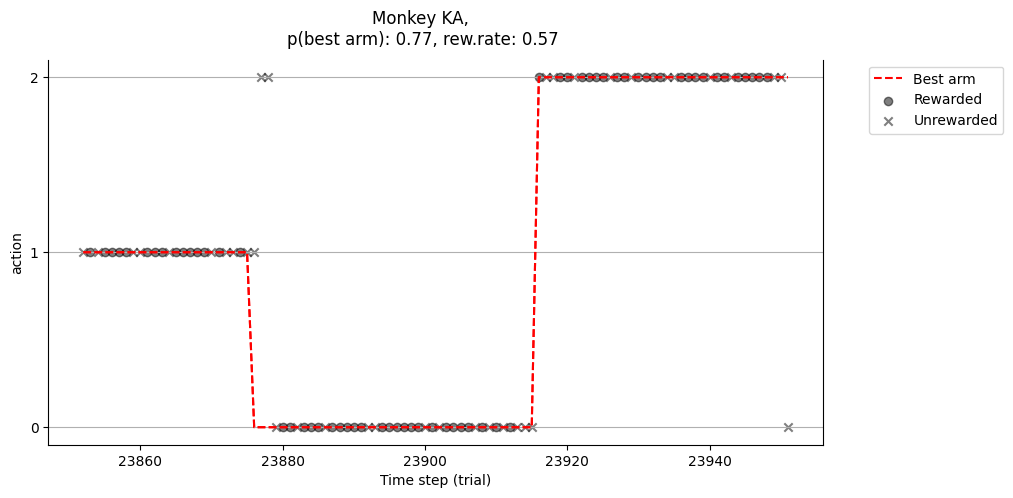

/Users/zsombi/Library/CloudStorage/GoogleDrive-uuungvarszi@gmail.com/Other computers/My Mac/ZSOMBI/SBRI/PoPy/notebooks/behav_modeling/plotting_helpers.py:136: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper center', bbox_to_anchor=(.5, -.5), ncol=1)


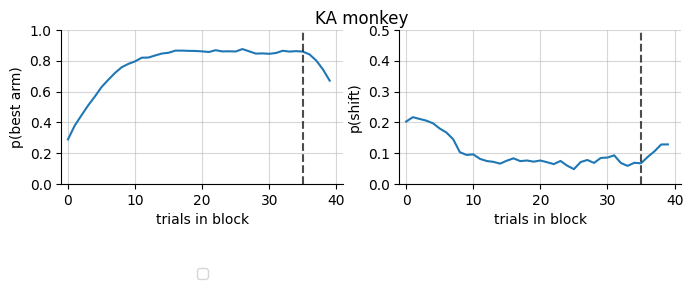

/Users/zsombi/Library/CloudStorage/GoogleDrive-uuungvarszi@gmail.com/Other computers/My Mac/ZSOMBI/SBRI/PoPy/notebooks/behav_modeling/plotting_helpers.py:240: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1)


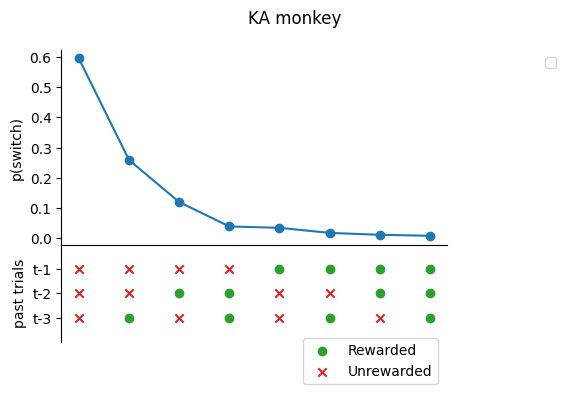

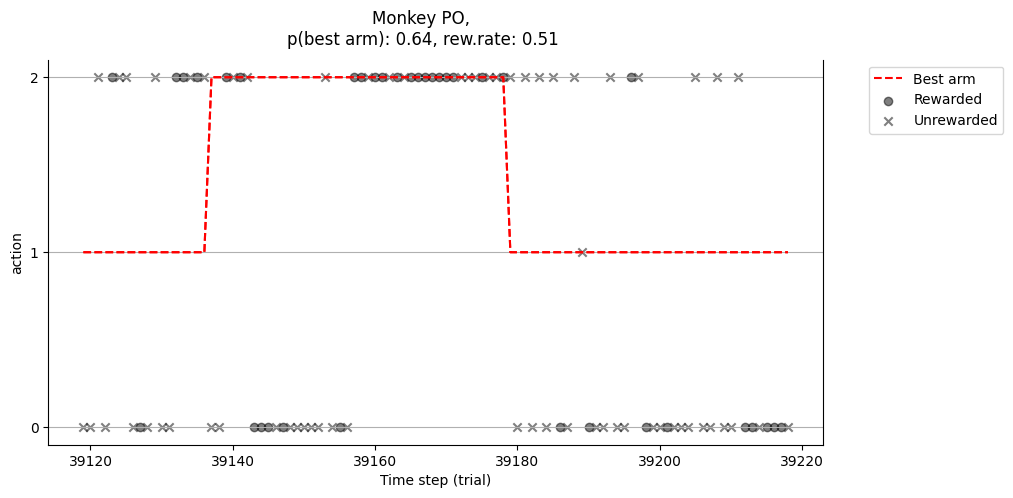

/Users/zsombi/Library/CloudStorage/GoogleDrive-uuungvarszi@gmail.com/Other computers/My Mac/ZSOMBI/SBRI/PoPy/notebooks/behav_modeling/plotting_helpers.py:136: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper center', bbox_to_anchor=(.5, -.5), ncol=1)


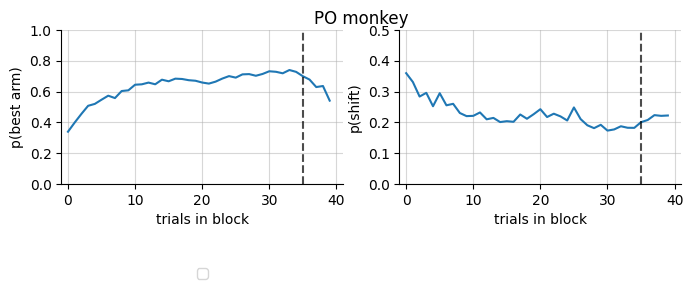

/Users/zsombi/Library/CloudStorage/GoogleDrive-uuungvarszi@gmail.com/Other computers/My Mac/ZSOMBI/SBRI/PoPy/notebooks/behav_modeling/plotting_helpers.py:240: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1)


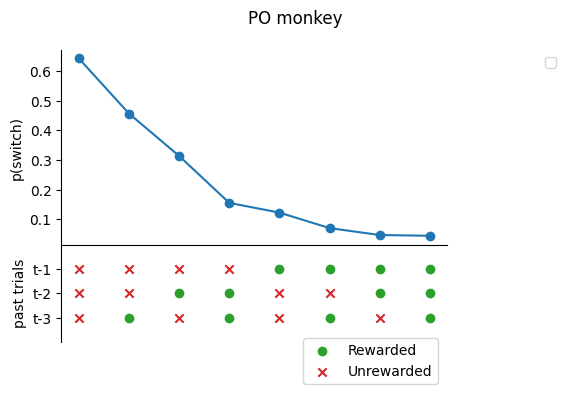

In [5]:
if prot_individual_results:
    # plot the behavior
    plot_monkey_agent(behav_monkey_ka, monkey_name='ka')
    plot_summary_stats(behav_monkey_ka, title='KA monkey')
    plot_hist_thingy(behav_monkey_ka, title='KA monkey')

    plot_monkey_agent(behav_monkey_po, monkey_name='po')
    plot_summary_stats(behav_monkey_po, title='PO monkey')
    plot_hist_thingy(behav_monkey_po, title='PO monkey')

---
# Section 0. Win-Stay-Lose-Shift Agent

This agent follows a simple form of win-stay-lose-shift strategy, where it stays it there were a reward in the ***LAST TWO trials***, and shifts otherwise.

## Section 0.1. Advanced WSLS model

In [6]:
# Define parameter space for ShiftValueAgent
agent_class = WSLSAgent_custom

fixed_params = {}

# fit the agent
'''param_space = [
    Real(0.0, .3, name='epsilon'),
]

res_temp = fit_agent(agent_class, param_space, env, 
                    fixed_params=fixed_params,
                    fit_on='rr',
                    make_plots=True, verbose=False,
                    n_calls=40, n_initial_points=10)
                    
best_params = res_temp['best_params']
'''

# get best params from previous run
best_params = {'epsilon': 9.451810306959631e-06} 

# simulate the agent
behavior_wsls = simulate_agent(agent_class, best_params, env, fixed_params=None, behavioral_variables=[])

print(f'Best parameters: \n{best_params}')

Best parameters: 
{'epsilon': 9.451810306959631e-06}


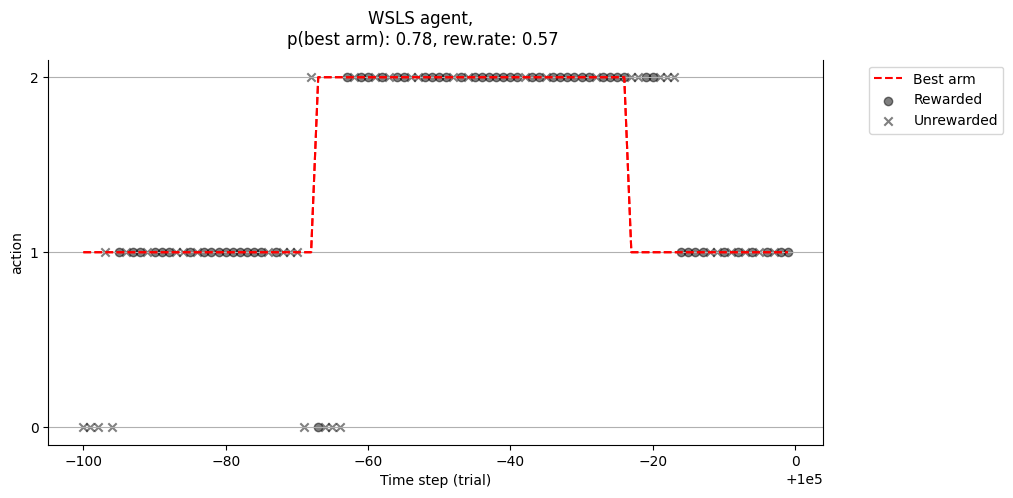

/Users/zsombi/Library/CloudStorage/GoogleDrive-uuungvarszi@gmail.com/Other computers/My Mac/ZSOMBI/SBRI/PoPy/notebooks/behav_modeling/plotting_helpers.py:136: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper center', bbox_to_anchor=(.5, -.5), ncol=1)


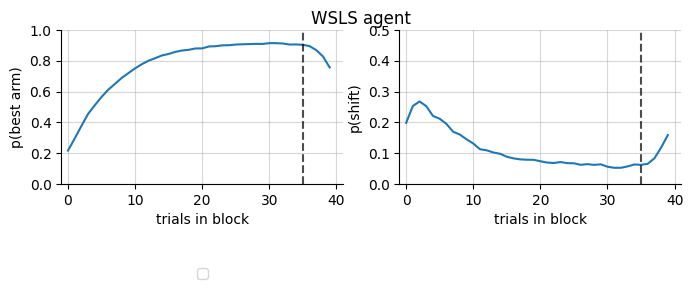

/Users/zsombi/Library/CloudStorage/GoogleDrive-uuungvarszi@gmail.com/Other computers/My Mac/ZSOMBI/SBRI/PoPy/notebooks/behav_modeling/plotting_helpers.py:240: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1)


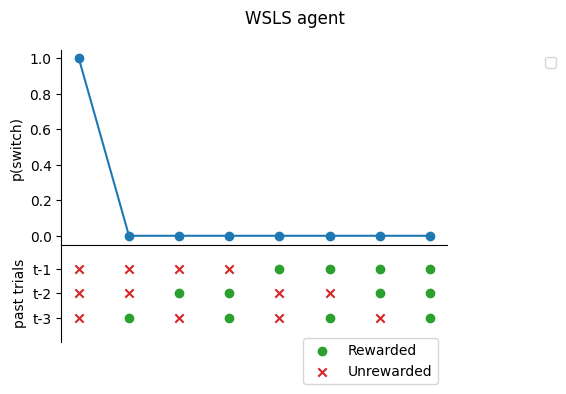

In [7]:
if prot_individual_results:
    # plot the behavior
    plot_wsls_agent(behavior_wsls)
    plot_summary_stats(behavior_wsls, title='WSLS agent')
    plot_hist_thingy(behavior_wsls, title='WSLS agent')

---
# Section 1. A Q-learning Agent

## Section 1.1. No cross-learning

In [8]:
'''agent_class = QLearner

params = {
    'alpha': .7341,
    'beta': 20,  # rate of exploration (i.e. random actions)
}

fixed_params = {
    'structure_aware': False
}

# simulate the agent
behavior_qlearn = simulate_agent(agent_class, params, env, fixed_params, behavioral_variables=['q_values'])
'''

# Define parameter space for ShiftValueAgent
agent_class = QLearner

fixed_params = {
    'structure_aware': False
}

# fit the agent
'''
param_space = [
    Real(.3, .9, name='alpha'),
    Real(10, 80, name='beta'),
]

res_temp = fit_agent(agent_class, param_space, env, 
                    fixed_params=fixed_params,
                    fit_on='rr',
                    make_plots=True, verbose=False,
                    n_calls=150, n_initial_points=100)

best_params = res_temp['best_params']
'''

# get best params from previous run
best_params = {'alpha': 0.8149496594188124, 'beta': 42.18484579352481}

# simulate the agent
behavior_qlearn = simulate_agent(agent_class, best_params, env, fixed_params, behavioral_variables=['q_values'])

print(f'Best parameters: \n{best_params}')

Best parameters: 
{'alpha': 0.8149496594188124, 'beta': 42.18484579352481}


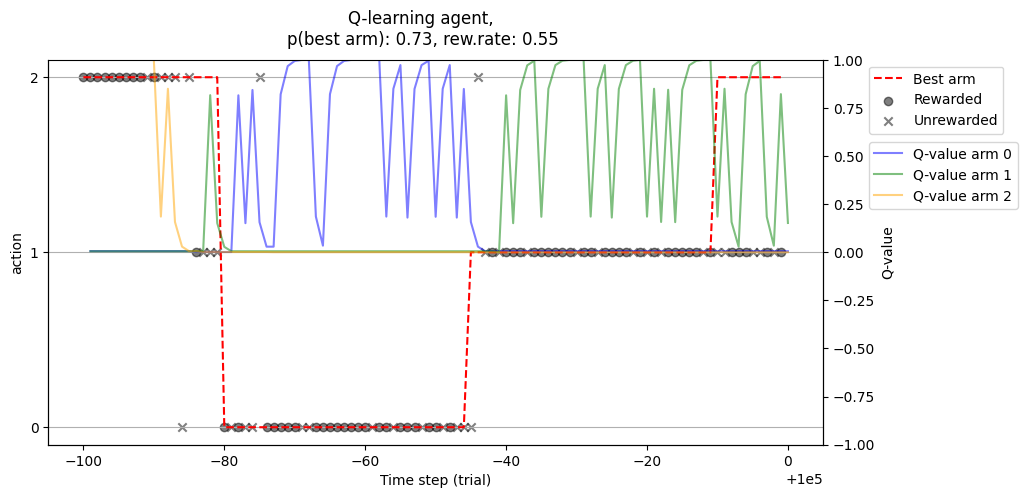

/Users/zsombi/Library/CloudStorage/GoogleDrive-uuungvarszi@gmail.com/Other computers/My Mac/ZSOMBI/SBRI/PoPy/notebooks/behav_modeling/plotting_helpers.py:136: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper center', bbox_to_anchor=(.5, -.5), ncol=1)


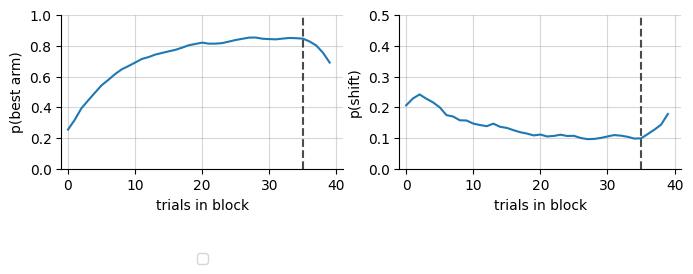

/Users/zsombi/Library/CloudStorage/GoogleDrive-uuungvarszi@gmail.com/Other computers/My Mac/ZSOMBI/SBRI/PoPy/notebooks/behav_modeling/plotting_helpers.py:240: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1)


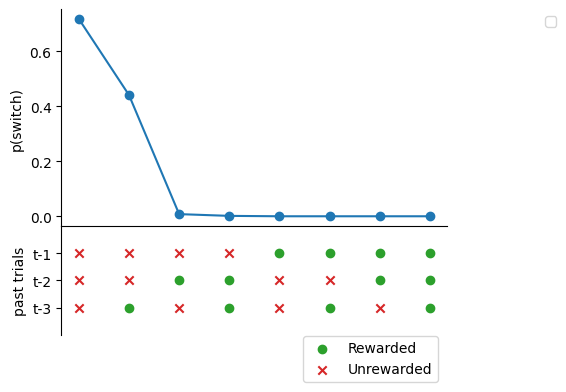

In [9]:
if prot_individual_results:
    # plot the behavior
    plot_q_agent(behavior_qlearn)
    plot_summary_stats(behavior_qlearn)
    plot_hist_thingy(behavior_qlearn)

## Section 1.2. Cross-learning allowed (MODEL IV)

In [10]:
'''agent_class = QLearner

params = {
    'alpha': 0.1040,
    'beta': 60,  # rate of exploration (i.e. random actions)
}

fixed_params = {
    'structure_aware': True
}

# simulate the agent
behavior_qlearn_counterfactual = simulate_agent(agent_class, params, env, fixed_params, behavioral_variables=['q_values'])

'''

# Define parameter space for ShiftValueAgent
agent_class = QLearner

fixed_params = {
    'structure_aware': True
}

# fit the agent
'''

param_space = [
    Real(.01, .4, name='alpha'),
    Real(10, 80, name='beta'),
]

res_temp = fit_agent(agent_class, param_space, env, 
                    fixed_params=fixed_params,
                    fit_on='rr',
                    make_plots=True, verbose=False,
                    n_calls=150, n_initial_points=100)

best_params = res_temp['best_params']
'''

# get best params from previous run
best_params = {'alpha': 0.1301733966408454, 'beta': 66.81579533811015}

# simulate the agent
behavior_qlearn_counterfactual = simulate_agent(agent_class, best_params, env, fixed_params, behavioral_variables=['q_values'])

print(f'Best parameters: \n{best_params}')

Best parameters: 
{'alpha': 0.1301733966408454, 'beta': 66.81579533811015}


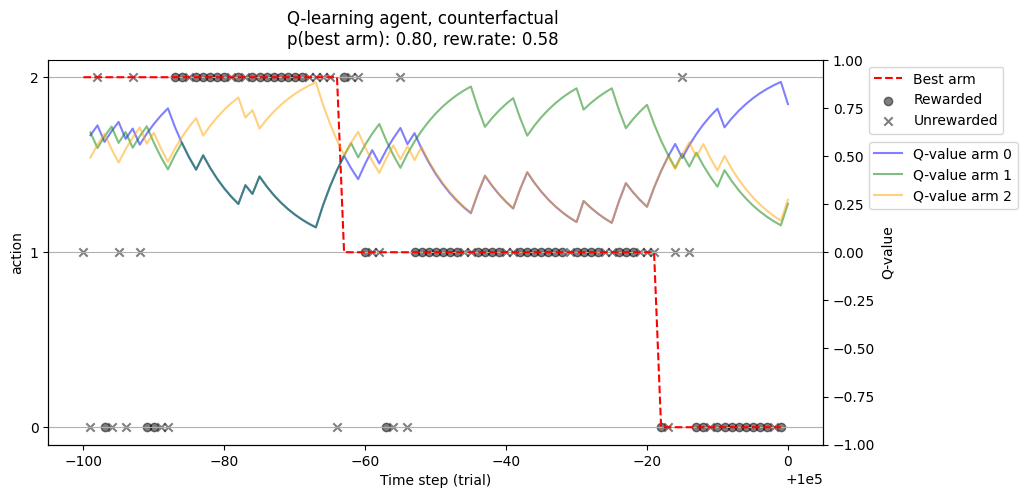

/Users/zsombi/Library/CloudStorage/GoogleDrive-uuungvarszi@gmail.com/Other computers/My Mac/ZSOMBI/SBRI/PoPy/notebooks/behav_modeling/plotting_helpers.py:136: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper center', bbox_to_anchor=(.5, -.5), ncol=1)


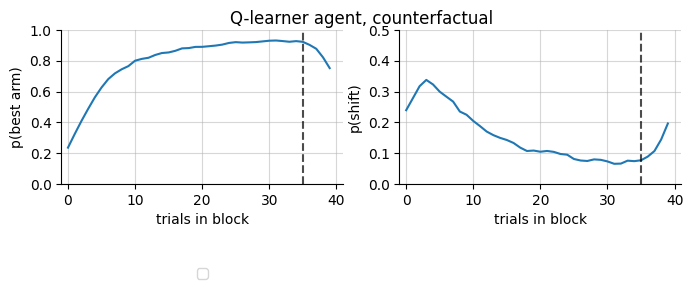

/Users/zsombi/Library/CloudStorage/GoogleDrive-uuungvarszi@gmail.com/Other computers/My Mac/ZSOMBI/SBRI/PoPy/notebooks/behav_modeling/plotting_helpers.py:240: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1)


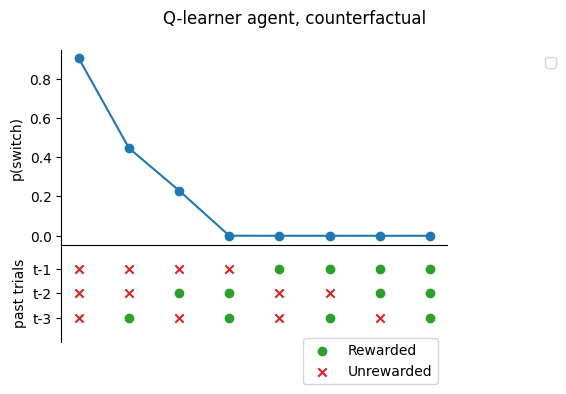

In [11]:
if prot_individual_results:
    # plot the behavior
    plot_q_agent(behavior_qlearn_counterfactual, title='Q-learning agent, counterfactual')
    plot_summary_stats(behavior_qlearn_counterfactual, title='Q-learner agent, counterfactual')
    plot_hist_thingy(behavior_qlearn_counterfactual, title='Q-learner agent, counterfactual')

---
# Section 2. Strategy Value Agent


## Section 2.1.1. No CMW (MODEL I)

In [12]:
'''agent_class = ShiftValueAgent

params = {
    'alpha': 0.4770,
    'beta': 98.10,
    'V0': 0.1973
}

fixed_params = {
    'reset_on_switch': False
}

# simulate the agent
behavior_strategic = simulate_agent(agent_class, params, env, fixed_params, behavioral_variables=["V", "V0"])'''



# Define parameter space for ShiftValueAgent
agent_class = ShiftValueAgent

fixed_params = {
    'reset_on_switch': False
}

# fit the agent
'''
param_space = [
    Real(.1, .8, name='alpha'),
    Real(10, 100, name='beta'),
    Real(0, 1, name='V0'),
]

res_temp = fit_agent(agent_class, param_space, env, 
                    fixed_params=fixed_params,
                    fit_on='rr',
                    make_plots=True, verbose=False,
                    n_calls=150, n_initial_points=100)

best_params = res_temp['best_params']
'''
# get best params from previous run
best_params = {'alpha': 0.41728277205284503, 'beta': 100.0, 'V0': 0.21028761393188744}

# simulate the agent
behavior_strategic = simulate_agent(agent_class, best_params, env, fixed_params, behavioral_variables=["V", "V0"])

print(f'Best parameters: \n{best_params}')

Best parameters: 
{'alpha': 0.41728277205284503, 'beta': 100.0, 'V0': 0.21028761393188744}


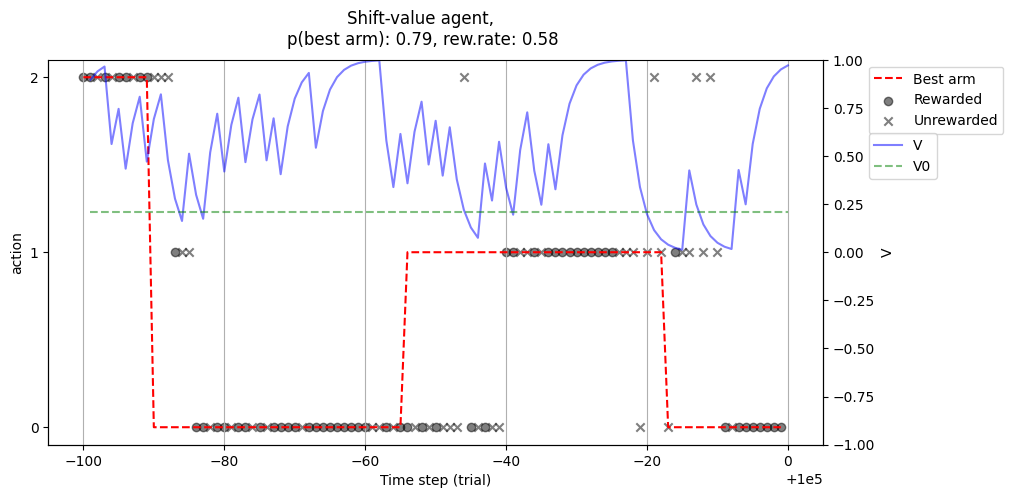

/Users/zsombi/Library/CloudStorage/GoogleDrive-uuungvarszi@gmail.com/Other computers/My Mac/ZSOMBI/SBRI/PoPy/notebooks/behav_modeling/plotting_helpers.py:136: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper center', bbox_to_anchor=(.5, -.5), ncol=1)


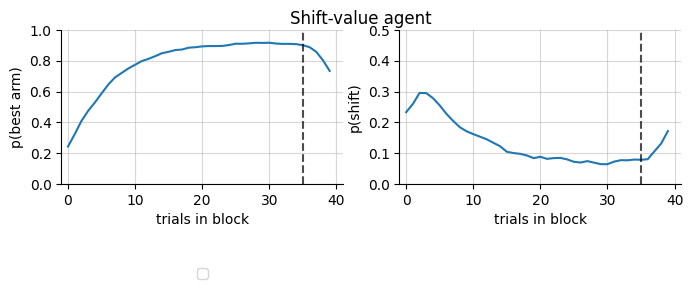

/Users/zsombi/Library/CloudStorage/GoogleDrive-uuungvarszi@gmail.com/Other computers/My Mac/ZSOMBI/SBRI/PoPy/notebooks/behav_modeling/plotting_helpers.py:240: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1)


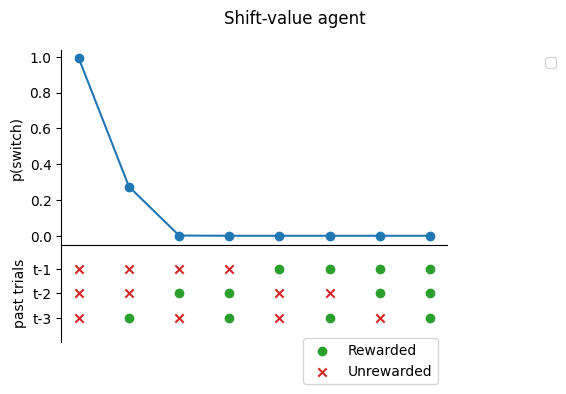

In [13]:
if prot_individual_results:
    # plot the behavior
    plot_strategy_value_agent(behavior_strategic)
    plot_summary_stats(behavior_strategic, title='Shift-value agent')
    plot_hist_thingy(behavior_strategic, title='Shift-value agent')

## Section 2.1.2. Threshold (MODEL II)

In [14]:
'''agent_class = ShiftValueAgent

params = {
    'alpha': 0.4903,
    'beta': 71.26,
    'V0': 0.2062
}

fixed_params = {
    'reset_on_switch': True
}

# simulate the agent
behavior_strategic_reset = simulate_agent(agent_class, params, env, fixed_params, behavioral_variables=["V", "V0"])
'''


# Define parameter space for ShiftValueAgent
agent_class = ShiftValueAgent

fixed_params = {
    'reset_on_switch': True
}

# fit the agent
'''
param_space = [
    Real(.2, .7, name='alpha'),
    Real(10, 100, name='beta'),
    Real(0, 1, name='V0'),
]

res_temp = fit_agent(agent_class, param_space, env, 
                    fixed_params=fixed_params,
                    fit_on='rr',
                    make_plots=True, verbose=False,
                    n_calls=150, n_initial_points=100)

best_params = res_temp['best_params']
'''
# get best params from previous run
best_params = {'alpha': 0.39347550945240797, 'beta': 100, 'V0': 0.3071904640232717}

# simulate the agent
behavior_strategic_reset = simulate_agent(agent_class, best_params, env, fixed_params, behavioral_variables=["V", "V0"])

print(f'Best parameters: \n{best_params}')

Best parameters: 
{'alpha': 0.39347550945240795, 'beta': 100, 'V0': 0.3071904640232717}


In [15]:
# grid search
alpha_range = np.linspace(.01, 1, 50)
beta = 100
V0_range = np.linspace(0, 1, 50)

'''res_grid = np.zeros((len(alpha_range), len(V0_range)))

for i, alpha in enumerate(alpha_range):
    for j, V0 in enumerate(V0_range):
        params = {
            'alpha': alpha,
            'beta': beta,
            'V0': V0
        }
        behavior = simulate_agent(agent_class, params, env, fixed_params, behavioral_variables=["V", "V0"])

        prop_best_arm = (behavior["best_arm"].values == behavior["action"].values).mean()

        res_grid[i, j] = prop_best_arm

# save the results (numpy array)
floc = 'results/shift_value_agent_grid_search.npy'
np.save(floc, res_grid)'''

# load the results
floc = 'results/shift_value_agent_grid_search.npy'
res_grid = np.load(floc)

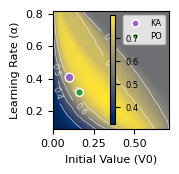

Plot area size: 2.95cm × 3.00cm


In [16]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.transforms import Bbox
import numpy as np

# Set font sizes
plt.rcParams.update({'font.size': 8})

# Create a larger figure to accommodate the axis labels and colorbar
fig = plt.figure(figsize=(5/2.54, 4/2.54))  # Slightly larger to fit everything

# Create axes with exact 3cm×3cm plot area (data display region)
ax = fig.add_axes([0.2, 0.2, 3/5, 3/4])  # Left, Bottom, Width, Height as fractions of figure size

# Create nice colormap for the heatmap
cmap = plt.cm.cividis

# Use your chopped data
res_grid_chopped = res_grid[4:41, 0:36]
alpha_range_chopped = alpha_range[4:41]
V0_range_chopped = V0_range[0:36]

im = ax.imshow(res_grid_chopped, origin='lower', 
               extent=[V0_range_chopped[0], V0_range_chopped[-1], alpha_range_chopped[0], alpha_range_chopped[-1]], 
               aspect='equal', interpolation='gaussian', cmap=cmap)

# Add contour lines at every 0.1 increment with minimal labels
levels = np.arange(0, 1, 0.1)
contour = ax.contour(
    np.linspace(V0_range_chopped[0], V0_range_chopped[-1], res_grid_chopped.shape[1]),
    np.linspace(alpha_range_chopped[0], alpha_range_chopped[-1], res_grid_chopped.shape[0]), 
    res_grid_chopped, levels=levels, colors='white', linewidths=0.5, alpha=0.7
)
# Only label a few contours to avoid clutter
ax.clabel(contour, inline=True, fontsize=6, fmt='%.1f', levels=levels)

# Add parameter points with compact styling
ka_params = {'alpha': 0.41, 'V0': 0.1}
po_params = {'alpha': 0.32, 'V0': 0.16}

ax.scatter(ka_params['V0'], ka_params['alpha'], color=COLORS['ka'], s=40, label='KA', 
          edgecolor='white', linewidth=1, zorder=10)
ax.scatter(po_params['V0'], po_params['alpha'], color=COLORS['po'], s=30, label='PO', 
          edgecolor='white', linewidth=1, zorder=10)

# Labels
ax.set_xlabel('Initial Value (V0)')
ax.set_ylabel('Learning Rate (α)')

# Add colorbar outside the main plot
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=-.50)
cbar.ax.tick_params(labelsize=6)

# Add compact legend
ax.legend(frameon=True, loc='upper right', fontsize=6, markerscale=0.8)

# Save with exact dimensions preserved
plt.savefig('figs/grid_search_shift_value_reset.svg', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# Verify the exact size of the plot area
bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
print(f"Plot area size: {bbox.width*2.54:.2f}cm × {bbox.height*2.54:.2f}cm")

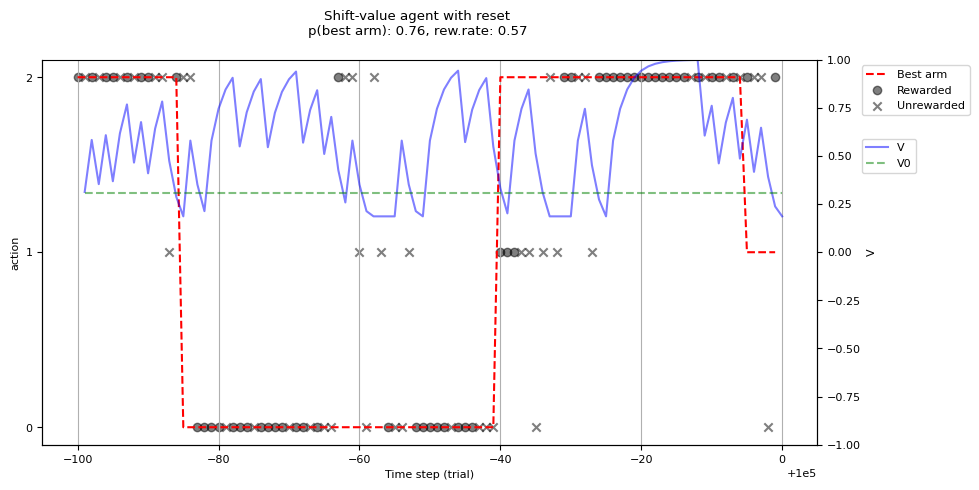

/Users/zsombi/Library/CloudStorage/GoogleDrive-uuungvarszi@gmail.com/Other computers/My Mac/ZSOMBI/SBRI/PoPy/notebooks/behav_modeling/plotting_helpers.py:136: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper center', bbox_to_anchor=(.5, -.5), ncol=1)


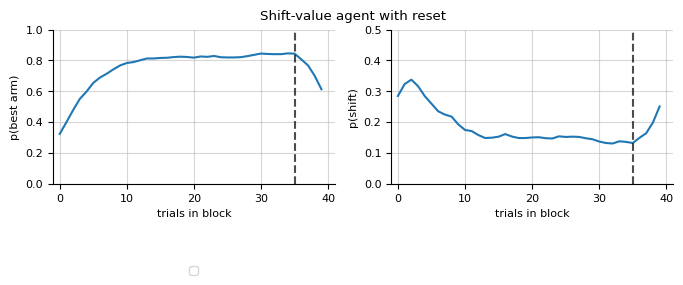

/Users/zsombi/Library/CloudStorage/GoogleDrive-uuungvarszi@gmail.com/Other computers/My Mac/ZSOMBI/SBRI/PoPy/notebooks/behav_modeling/plotting_helpers.py:240: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1)


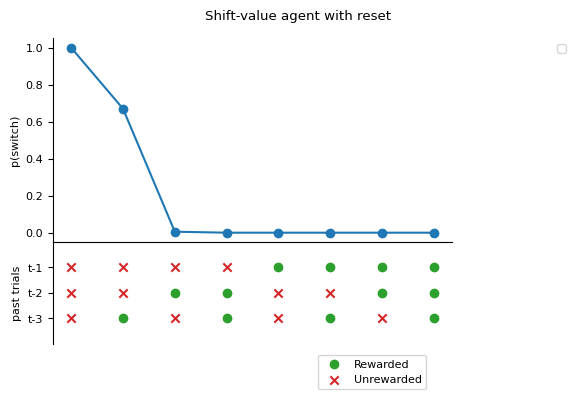

In [17]:
if prot_individual_results:
    # plot the behavior
    plot_strategy_value_agent(behavior_strategic_reset, title='Shift-value agent with reset')
    plot_summary_stats(behavior_strategic_reset, title='Shift-value agent with reset')
    plot_hist_thingy(behavior_strategic_reset, title='Shift-value agent with reset')

## Section 2.2. CMW agent (MODEL III)

---
# Section 3. HMM normative Agent

## Section 3.1. Model (MODEL V)

In [18]:
'''agent_class = BayesianAgent

params = {
    'beta': 100,
}

fixed_params = {
    'transition_matrix': np.array([[39/40, .5/40, .5/40], [.5/40, 39/40, .5/40], [.5/40, .5/40, 39/40]]),
    'emission_matrix_pos': np.array([[.7, .25, .25], [.25, .7, .25], [.25, .25, .7]]),
    'emission_matrix_neg': np.array([[.3, .75, .75], [.75, .3, .75], [.75, .75, .3]]),
}

# simulate the agent
behavior_bayes = simulate_agent(agent_class, params, env, fixed_params, behavioral_variables=['posterior'])
'''

# Define parameter space for ShiftValueAgent
agent_class = BayesianAgent

fixed_params = {
    'transition_matrix': np.array([[39/40, .5/40, .5/40], [.5/40, 39/40, .5/40], [.5/40, .5/40, 39/40]]),
    'emission_matrix_pos': np.array([[.7, .25, .25], [.25, .7, .25], [.25, .25, .7]]),
    'emission_matrix_neg': np.array([[.3, .75, .75], [.75, .3, .75], [.75, .75, .3]]),
}

# fit the agent
'''
param_space = [
    Real(10, 100, name='beta'),
]

res_temp = fit_agent(agent_class, param_space, env, 
                    fixed_params=fixed_params,
                    fit_on='rr',
                    make_plots=True, verbose=False,
                    n_calls=150, n_initial_points=100)

best_params = res_temp['best_params']
'''
# get best params from previous run
best_params = {'beta': 97.57890463202423}

# simulate the agent
behavior_bayes = simulate_agent(agent_class, best_params, env, fixed_params, behavioral_variables=['posterior'])

print(f'Best parameters: \n{best_params}')

Best parameters: 
{'beta': 97.57890463202423}


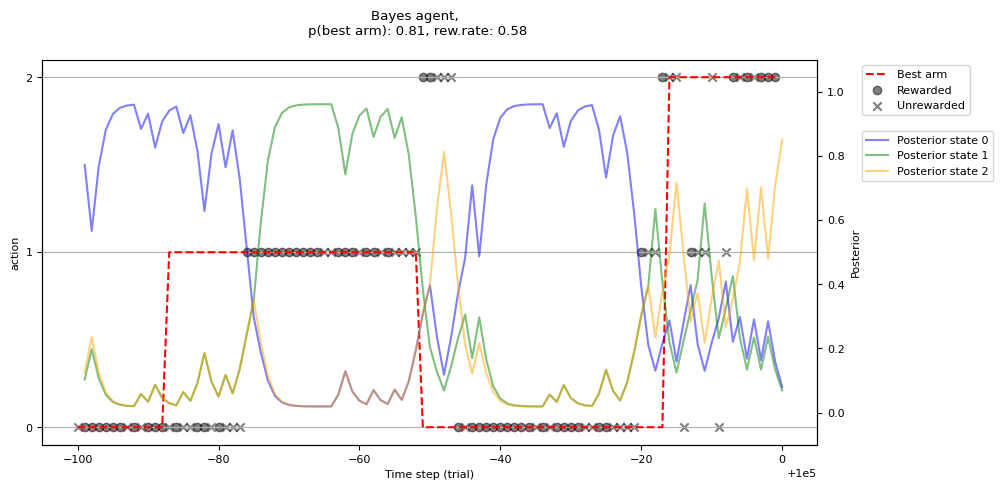

/Users/zsombi/Library/CloudStorage/GoogleDrive-uuungvarszi@gmail.com/Other computers/My Mac/ZSOMBI/SBRI/PoPy/notebooks/behav_modeling/plotting_helpers.py:136: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper center', bbox_to_anchor=(.5, -.5), ncol=1)


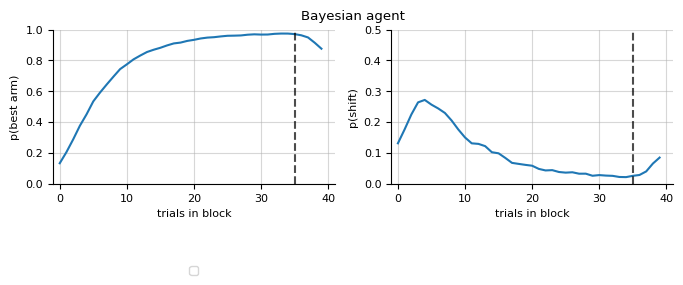

/Users/zsombi/Library/CloudStorage/GoogleDrive-uuungvarszi@gmail.com/Other computers/My Mac/ZSOMBI/SBRI/PoPy/notebooks/behav_modeling/plotting_helpers.py:240: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1)


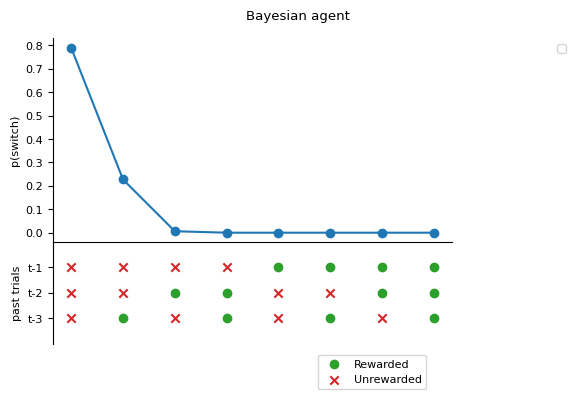

In [19]:
if prot_individual_results:
    # plot the behavior
    plot_bayesian_bandit(behavior_bayes)
    plot_summary_stats(behavior_bayes, title='Bayesian agent')
    plot_hist_thingy(behavior_bayes, title='Bayesian agent')

---
# Summary

In [ ]:

def plot_performances(behavs, y_label=None, title=None):
    h = 4  # height of the plot in cm
    w = 4  # width of the plot in cm
    fig, ax = plt.subplots(1, 1, figsize=(w/2.54, h/2.54))
    for key, value in behavs.items():
        prop_best_arm = (value["best_arm"].values == value["action"].values).mean()
        mean_rr = value["reward"].mean()

        if key == 'Bayesian':
            ax.axhline(prop_best_arm, color='black', linestyle='--', label='Normative')
        else:

            if key == 'MONKEY KA':
                color = COLORS['ka']
            elif key == 'MONKEY PO':
                color = COLORS['po']
            else:
                color = 'grey'

            ax.bar(key, prop_best_arm, alpha=0.8, color=color, zorder=2, edgecolor='black', linewidth=0.5)

    # rotate x-axis labels
    plt.xticks(rotation=90)

    #ax.set_ylabel("Proportion of best arm choices")
    #ax.set_title("Performance of different agents")
    ax.set_ylim(0.5, .85)
    if y_label is not None:
        ax.set_ylabel(y_label)
    if title is not None:
        ax.set_title(title)
    # yticks at every .1
    ax.set_yticks(np.arange(0.5, .85, .1))
    ax.grid(axis="y", zorder=0, alpha=.5)
    #ax.grid(axis="y", zorder=0)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # save the figure
    plt.savefig('figs/performances.svg', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

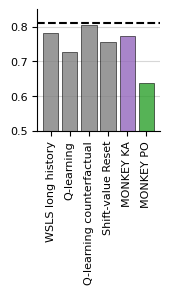

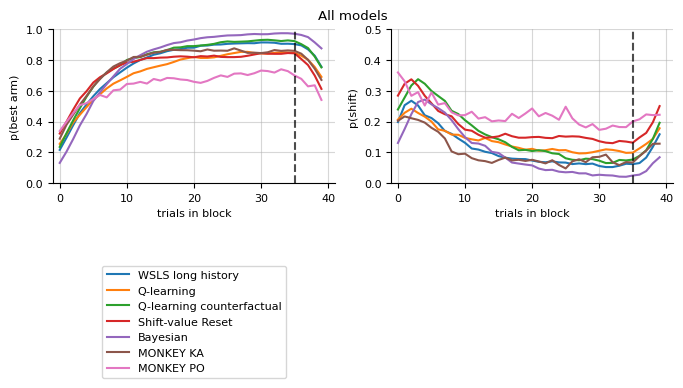

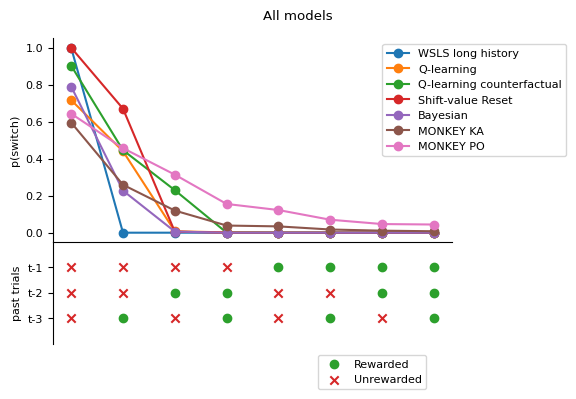

In [21]:
# plot the learning curves and the proba shift together
behavs = {
    'WSLS long history': behavior_wsls,
    'Q-learning': behavior_qlearn,
    'Q-learning counterfactual': behavior_qlearn_counterfactual,
    #'Shift-value': behavior_strategic,
    'Shift-value Reset': behavior_strategic_reset,
    'Bayesian': behavior_bayes,
    'MONKEY KA': behav_monkey_ka,  
    'MONKEY PO': behav_monkey_po
}

plot_performances(behavs)
# remove monkeys
'''
behavs.pop('MONKEY KA')
behavs.pop('MONKEY PO')
'''
plot_summary_stats(behavs, title='All models')
plot_hist_thingy(behavs, title='All models')